Found 300 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.8283 - loss: 0.3918
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9289 - loss: 0.2071
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9522 - loss: 0.1547
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9622 - loss: 0.1272
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9672 - loss: 0.1126
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9722 - loss: 0.0970
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9794 - loss: 0.0831
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9844 - loss: 0.0729
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.9856 - loss: 0.0681
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9894 - loss: 0.0592
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - acc

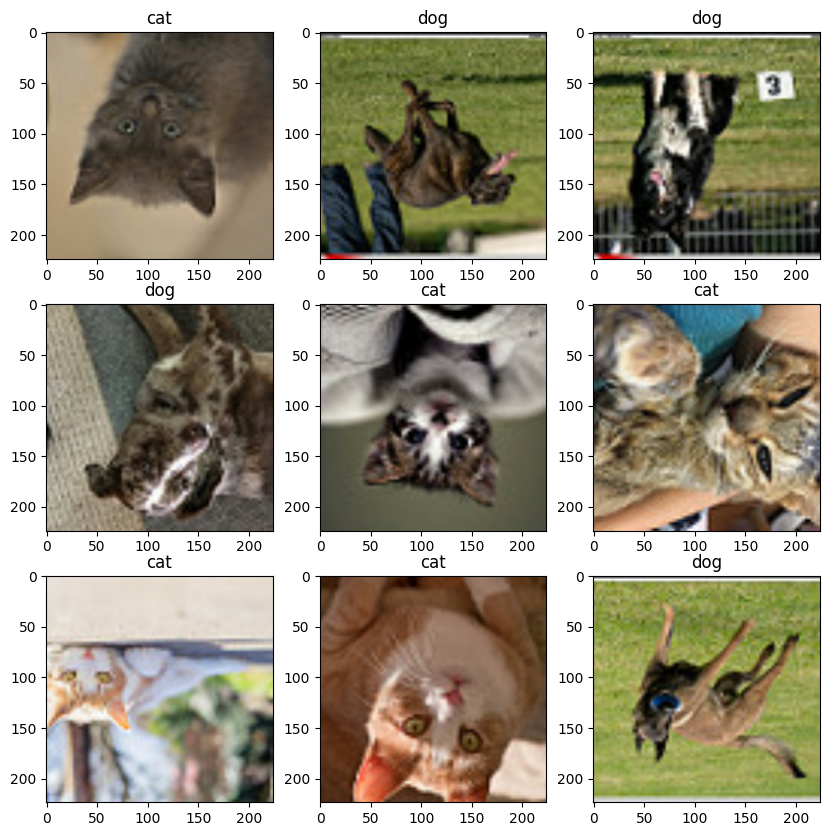

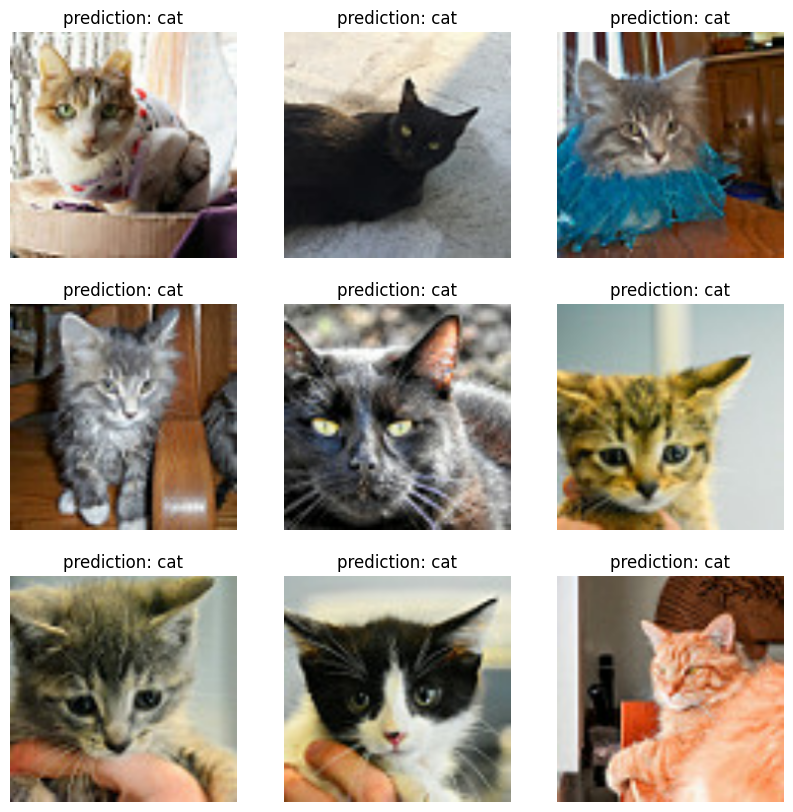

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9600 - loss: 0.0658


[0.06584174931049347, 0.9599999785423279]

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt

#エラーの一時対応でダウンロードしたファイルを指定 Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1010)
DOWNLOAD_FILE = "/Users/hinoue/Downloads/pythondev/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"

# 訓練データとテストデータの画像を読み込む
# （サイズは縦横224pxにリサイズする）
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dog_cat_photos/train",
    image_size=(224,224),
    batch_size=32,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dog_cat_photos/test",
    image_size=(224,224),
    batch_size=32,
    shuffle=False  
)

# 分類名（cat／dog）をリストとして格納する
class_names = train_dataset.class_names

# 画像の水増しをする関数の定義
def flip_left_right(image, label):   # 左右反転
    image = tf.image.flip_left_right(image)
    return image, label

def flip_up_down(image, label):      # 上下反転
    image = tf.image.flip_up_down(image)
    return image, label

def rot90(image, label):             # 反時計回りに90度回転
    image = tf.image.rot90(image)
    return image, label

def rot180(image, label):            # 反時計回りに180度回転
    image = tf.image.rot90(image, k=2)
    return image, label

def rot270(image, label):            # 反時計回りに270度回転
    image = tf.image.rot90(image, k=3)
    return image, label

# 画像の水増し処理の実行
train_dataset_lr     = train_dataset.map(flip_left_right)
train_dataset_ud     = train_dataset.map(flip_up_down)
train_dataset_rot90  = train_dataset.map(rot90)
train_dataset_rot180 = train_dataset.map(rot180)
train_dataset_rot270 = train_dataset.map(rot270)

# 水増ししたデータを訓練データに追加する
train_dataset = train_dataset.concatenate(train_dataset_lr)
train_dataset = train_dataset.concatenate(train_dataset_ud)
train_dataset = train_dataset.concatenate(train_dataset_rot90)
train_dataset = train_dataset.concatenate(train_dataset_rot180)
train_dataset = train_dataset.concatenate(train_dataset_rot270)

# データをシャッフルする
train_dataset = train_dataset.shuffle(1800)


# 訓練データの一部を表示して確認
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")])

# MobileNetV2モデルを作成する
input_layer = tf.keras.Input(shape=(224,224,3))
l_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224,224,3),
    input_tensor=l_layer,
    include_top=False,
    weights=DOWNLOAD_FILE,
    pooling='avg'
)
base_model.trainable = False

# Dense層を追加する
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# base_modelにDense層を追加したモデルを作成する
model = tf.keras.Sequential([
    base_model,
    output_layer
])

# modelをcompileする
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=["accuracy"])

# modelに学習させる(epochsの値が多いと実行に時間が掛かるので少ない値にしています)
model.fit(train_dataset, epochs=20)

# テストデータで分類を実行する
predictions = model.predict(test_dataset)

# 0.5より大きい場合はクラス1「犬」、それ以外はクラス0「猫」
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# テストデータセットから画像とラベルを取得
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):  # 最初の9枚の画像を表示
        ax = plt.subplot(3, 3, i + 1)
        # 画像を表示
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_label = class_names[predicted_classes[i]]
        # 犬か猫の予測を表示
        plt.title(f"prediction: {predicted_label}")
        plt.axis("off")
plt.show()

# evaluate()でモデルの性能を評価する
model.evaluate(test_dataset)